In [4]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv
import seaborn as sns
from matplotlib.axis import Axis
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from moepy import lowess

# Process Information Taken from Raw Files

## Import our Previously Extracted Data

In [5]:
record_list = [] # Initialize the array that will hold the list of our records

records = 'mit-bih-dataframes/subject_list.csv' # Get our record list like we did in the initial extraction
with open(records) as rfile:# Load our records into the array
    for record in rfile:
        record = record[0:-1] # The -1 removes the newline ("\n") character from the string
        record_list.append(record)

In [6]:
subject_dataframes = [] # Initialize our dataframe array

for x in tqdm(record_list): # Extract our dataframes from the CSVs we saved previously
    subject_dataframes.append(pd.read_csv('mit-bih-dataframes/'+x+'.csv', index_col=0))
            # 'index_col=0' loads the index that is saved into the csv as the index rather than another column

100%|██████████| 23/23 [01:35<00:00,  4.16s/it]


In [7]:

# Now we get the indexes of the R-Peaks from our dataframes
qrs = [] # Initialize the array that will hold our list of R-Peaks for each subject

for subject in tqdm(subject_dataframes): # Load each subject
    qrs.append([idx for idx, x in enumerate(subject['R-Peak']) if x]) # Then we use list comprehension to get our r peaks for each subject
                                                                # Recall, the indices that the R-Peak column is true is where there is an r-peak
                                                                # So, we iterate through and identify which indices that is for each subject

100%|██████████| 23/23 [00:18<00:00,  1.22it/s]


In [ ]:
#print(subject_dataframes[1])
#print(qrs[1])

## Extract RR-Intervals

In 2019, all of our developed variables were based on RR-Intervals, or the distance between adjacent R-Peaks. So, that is the first thing we extract 

In [8]:
rr_ints = [] # Initialize the array that will hold all of our subjects' RR-Intervals

# Then we want to Go through all of our data that holds our R-Peaks [That will be the qrs array]
# Iterating through that we want to extract the interval between each peak. 
# My suggested format is: 
"""
for each subject:
    for each rpeak sample_num in my current subject:
        subject_rrinterval.append( rpeak sample_num - the sample_num before it)
"""
for subject in tqdm(qrs):
    temp_array = []
    for index, rpeak in enumerate(subject):
        if index != 0:
            temp_array.append(rpeak - subject[index-1])
    rr_ints.append(temp_array)
#print(rr_ints[0])

100%|██████████| 23/23 [00:00<00:00, 60.35it/s]


In [9]:
rr_timeints = []
for subject in rr_ints:
    subject_time = []
    for interval in subject:
        time = interval/250
        if time <= 2 and time >= (1/3):
            subject_time.append(time)
        else:
            subject_time.append(-1)
    rr_timeints.append(subject_time)

In [10]:
#from Tutorial_Extract_MIT-BIH import atr_labels
subject_list = []
for integer in tqdm(range(0, 23)):    
    df = pd.DataFrame(
        {
            "Interval": rr_timeints[integer],
            "R-Peak": qrs[integer][1:],
            "Afib": subject_dataframes[integer]['AFIB'][qrs[integer][1:]],
            "Normal": subject_dataframes[integer]['Normal'][qrs[integer][1:]],
            "Other": subject_dataframes[integer]['Other'][qrs[integer][1:]],
    #        "Rhythm": main_list,
    #        'Indexes': index_list
        }
    )
    typelist = ['Normal', 'Afib', 'Other']
    main_list = []
    for index, row in df.iterrows():
        for types in typelist:
                if types == 'Normal' and row['Normal']:
                    main_list.append('N')
                elif types == 'Afib' and row['Afib']:
                    main_list.append('A')
                elif types == 'Other' and row['Other']:
                    main_list.append('O')
    df = df.assign(Rhythm=main_list)
    df = df.query('Interval != -1')
    subject_list.append(df)

100%|██████████| 23/23 [00:58<00:00,  2.52s/it]


 87%|████████▋ | 20/23 [00:15<00:01,  1.65it/s]C:\Users\Luke\AppData\Local\Temp\ipykernel_23576\3262293769.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize=(15,3)) #plot subplots
100%|██████████| 23/23 [00:16<00:00,  1.38it/s]


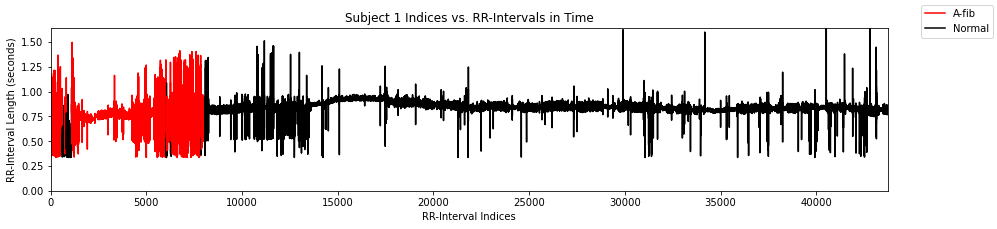

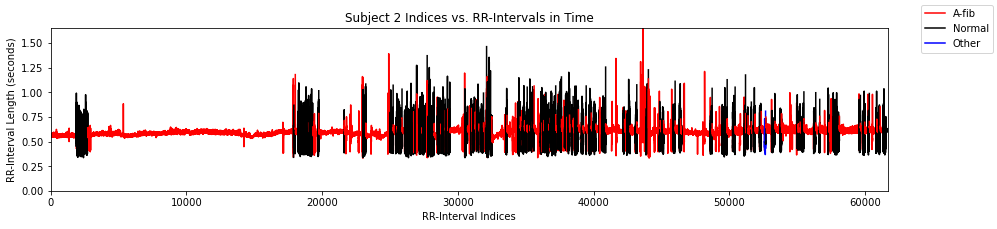

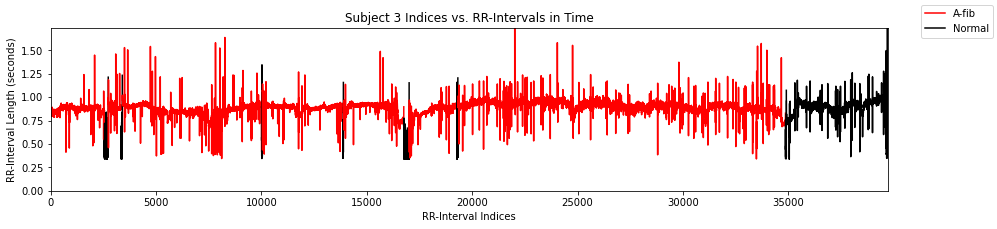

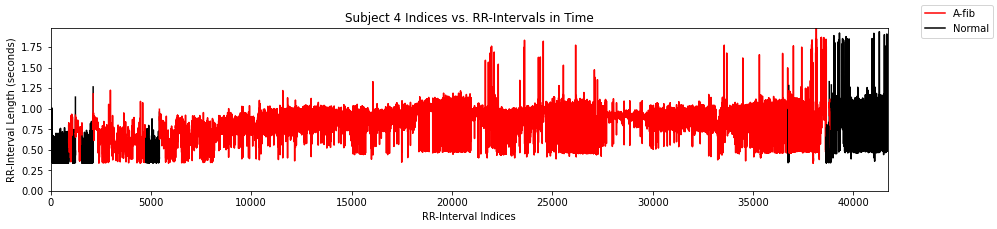

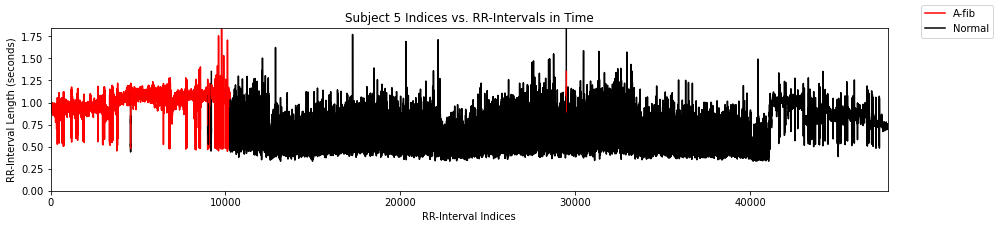

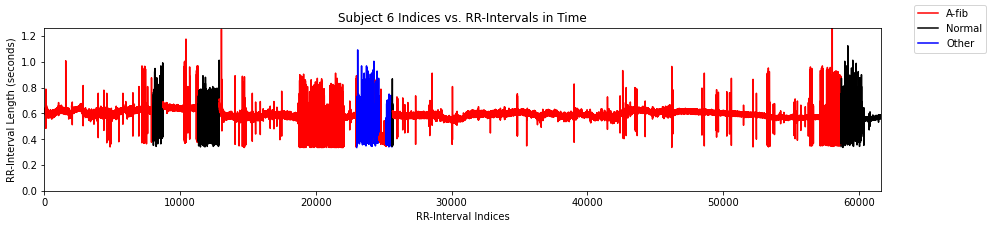

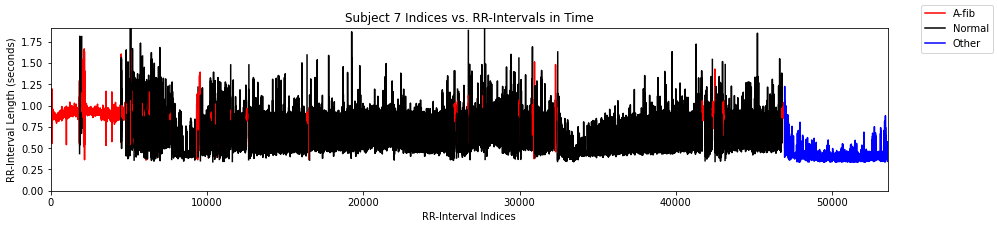

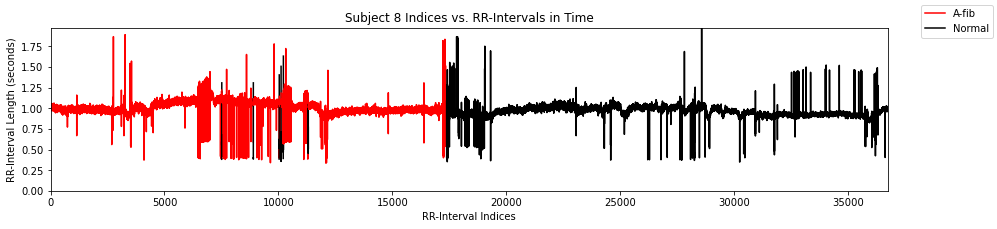

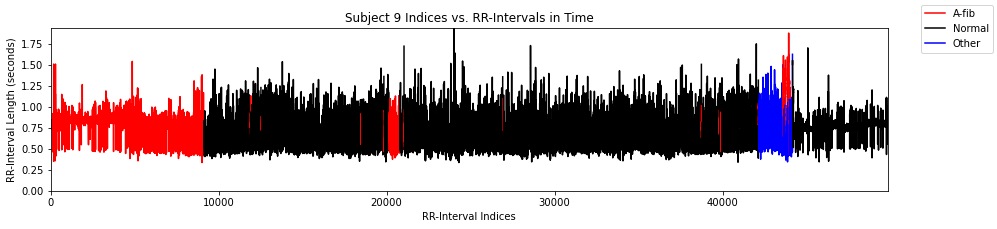

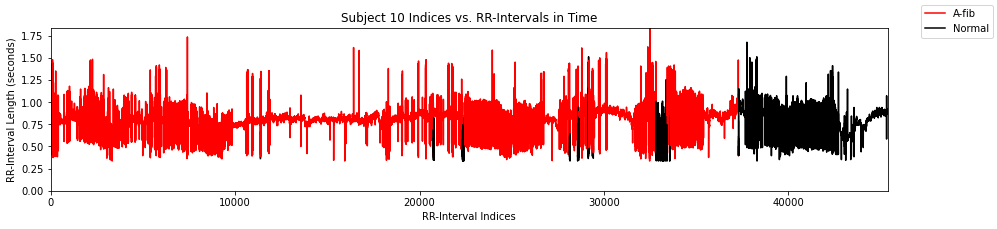

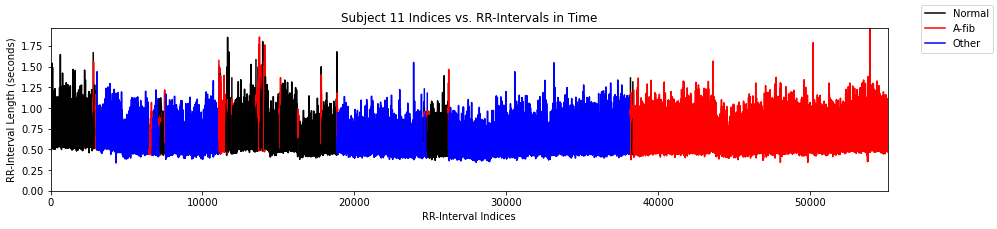

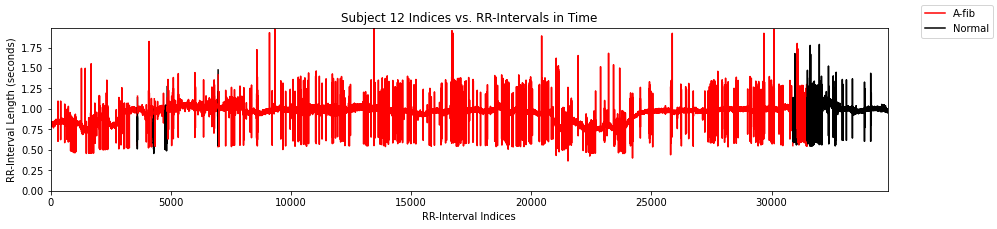

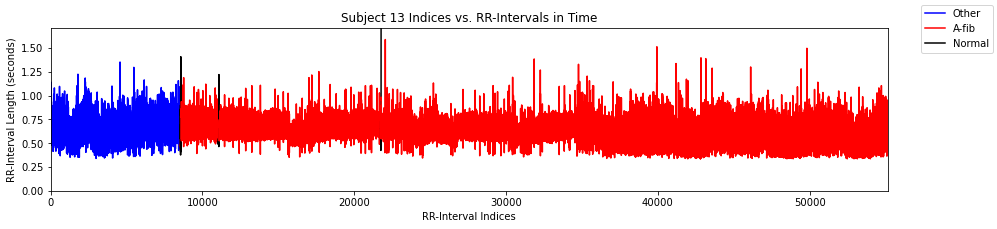

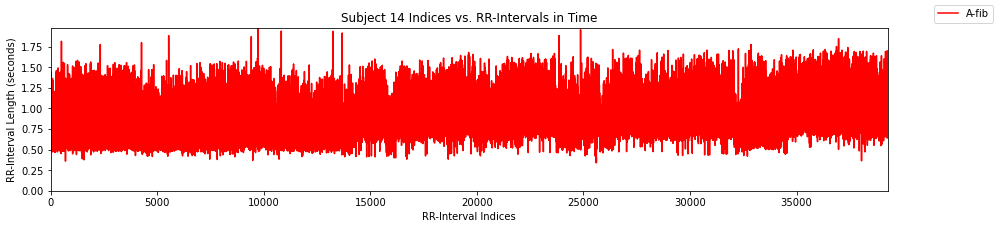

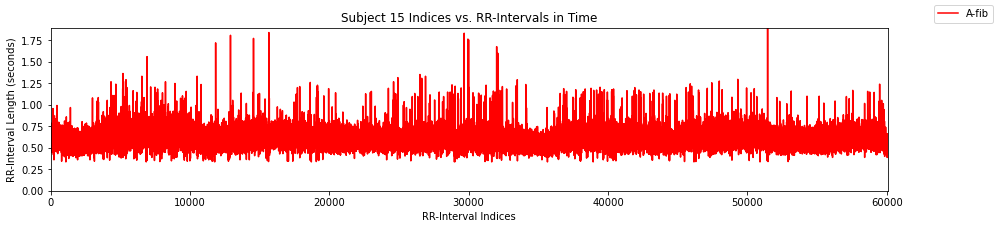

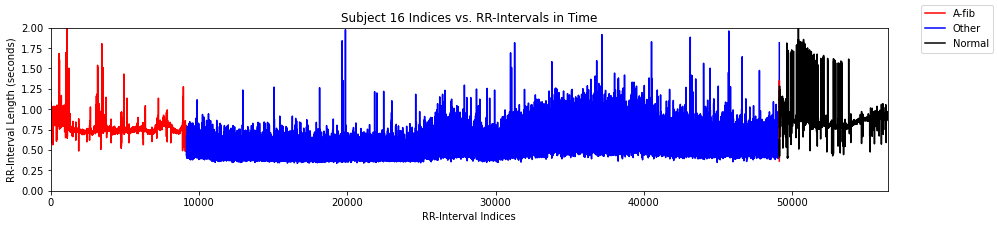

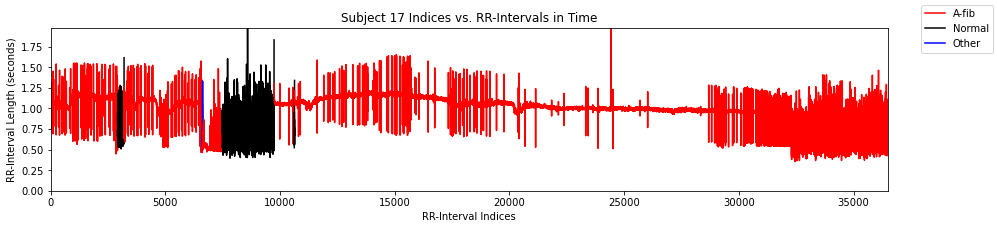

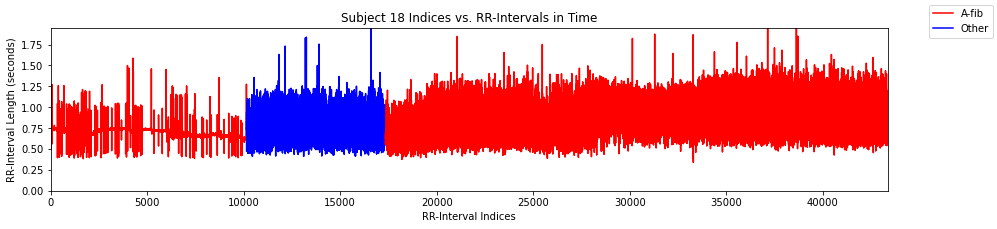

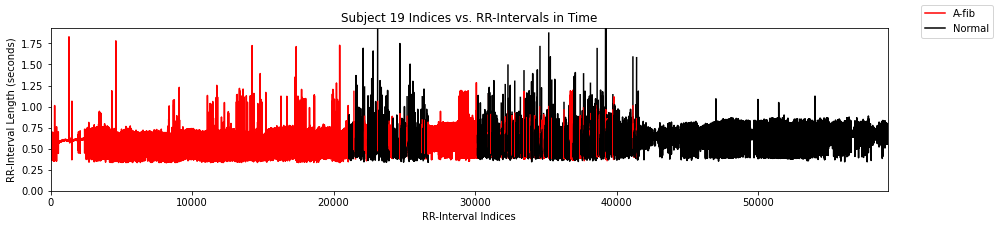

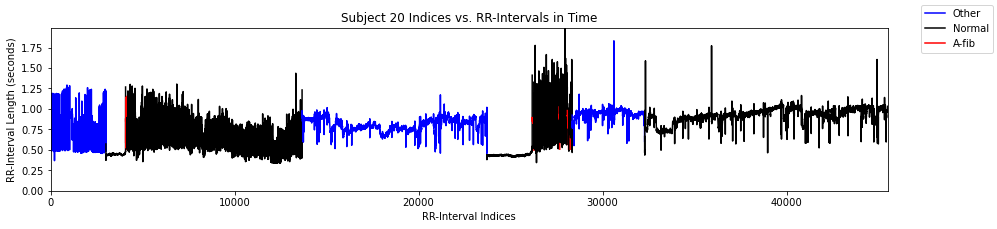

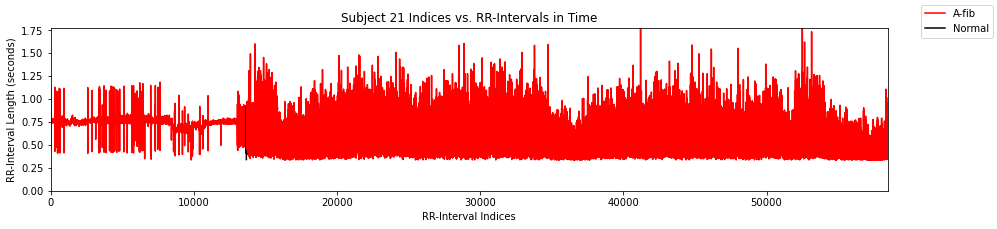

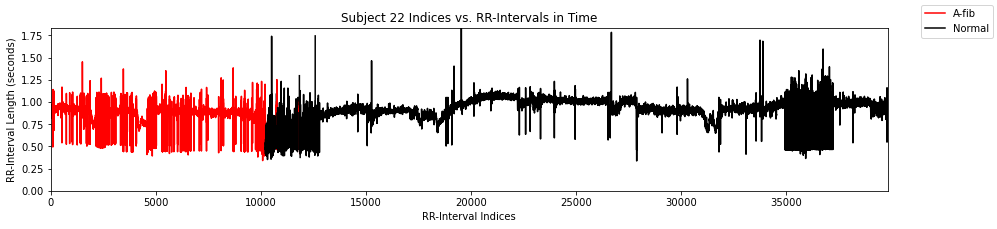

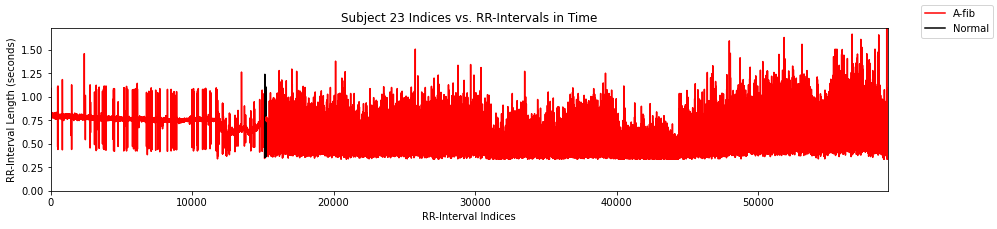

In [26]:
comp = '' #Compare when df['Rhythm'] changes from normal to Afib
counter = 0 #Upper bound for line
mini = 0 #(Minimum) Lower bound for line
subject_counter = 0 #Retrieve the specific subject array from rr_timeints
#labels = 'Red = A-fib, Black = Normal, Green = Other'

for df in tqdm(subject_list): #iterate through all subjects
    
    comp = ''
    counter = 0
    mini = 0
    ins_norm_counter = 0 #for figure legend
    ins_other_counter = 0 #for figure legend
    ins_afib_counter = 0 #for figure legend
    fig, axs = plt.subplots(figsize=(15,3)) #plot subplots
    plt.title('Subject ' + str(subject_counter+1) + ' Indices vs. RR-Intervals in Time')
    plt.xlabel('RR-Interval Indices')
    plt.ylabel('RR-Interval Length (seconds)')
    axs.set_xlim([0, len(df)])
    axs.set_ylim([0, max(df['Interval'])])
    
    #Set x and y for line of best fit
#     upper = len(df['Rhythm'])
#     indices_list = []
#     for num in range(0, upper):
#         indices_list.append(num)
#     x = np.array(indices_list)
#     y = df['Interval']#df['Interval']
    
    #find line of best fit
    #a, b = np.polyfit(x, y, 1)
    
#     lowess_model = lowess.Lowess()
#     lowess_model.fit(x, y)

#     # Model prediction
#     print('before')
#     x_pred = np.linspace(0, 65000, 100)
#     print('between')
#     y_pred = lowess_model.predict(x_pred)

#     # Plotting
#     plt.plot(x_pred, y_pred, '--', label='LOWESS', color='k', zorder=3)
#     plt.scatter(x, y, label='Noisy Sin Wave', color='C1', s=5, zorder=1)
#     plt.legend(frameon=False)

#     print('Hello')
    
    
    for item in df['Rhythm']: #iterate through each letter (rhythm) in each dataframe for each subject
        
        counter += 1
        
        if item != comp and comp != '':
            
            if item == 'N':
                if ins_norm_counter == 0:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='black',label = 'Normal')
                    ins_norm_counter += 1
                else:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='black')
            
            if item == 'O':
                if ins_other_counter == 0:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='b',label = 'Other')
                    ins_other_counter += 1
                else:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='b')
            
            if item == 'A':
                if ins_afib_counter == 0:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='red',label = 'A-fib')
                    ins_afib_counter += 1
                else:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='red')
            mini = counter #resets starting x to new one
        
        elif counter == len(df['Rhythm']):
            
            if item == 'N':
                if ins_norm_counter == 0:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='black',label = 'Normal')
                    ins_norm_counter += 1
                else:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='black')
            
            if item == 'O':
                if ins_other_counter == 0:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='b',label = 'Other')
                    ins_other_counter += 1
                else:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='b')
            
            if item == 'A':
                if ins_afib_counter == 0:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='red',label = 'A-fib')
                    ins_afib_counter += 1
                else:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='red')
        
        comp = item #comparator for each item in df['Rhythm']
    subject_counter += 1
    fig.legend(loc='upper right') #show legends
    
    #add line of best fit to plot
    #l1 = plt.plot(x, a*x+b, color='lime',linewidth=3)

        
plt.show()

In [ ]:
#SEE HISTOGRAMS BELOW

In [ ]:
#Example for how to stack histograms

x1= [23, 25, 40, 35, 40, 53, 33, 28, 55, 34, 20, 37, 36, 23, 33]
x2= [36, 20, 27, 50, 34, 47, 18, 28, 52, 21, 44, 34, 13, 40, 49]
colors = ['blue', 'orange']
labels = ['x1', 'x2']
fig, axs = plt.subplots()
axs.hist([x1, x2], stacked = True, color=colors, label = labels)
#axs.hist([x1], stacked = True, color=colors[0], label = labels[0])

fig.legend(loc='upper right')

 87%|████████▋ | 20/23 [00:18<00:02,  1.24it/s]C:\Users\Luke\AppData\Local\Temp\ipykernel_12128\146977133.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots()
100%|██████████| 23/23 [00:20<00:00,  1.11it/s]


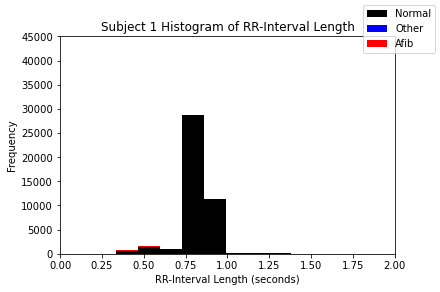

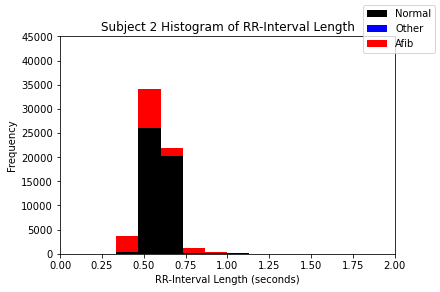

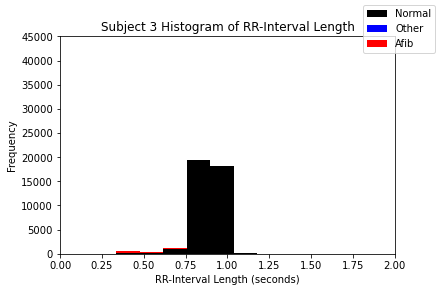

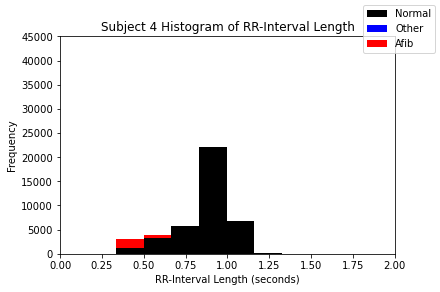

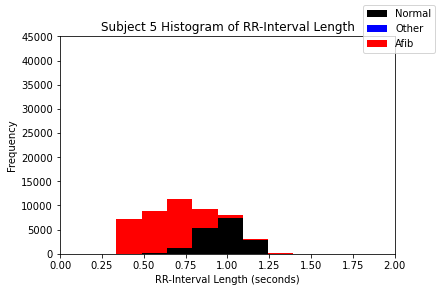

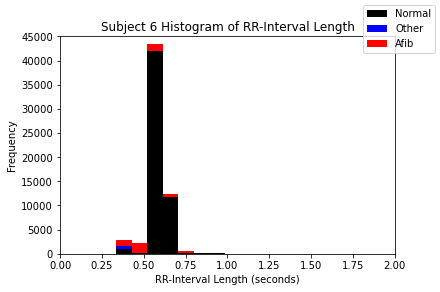

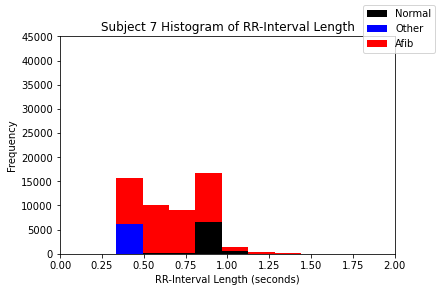

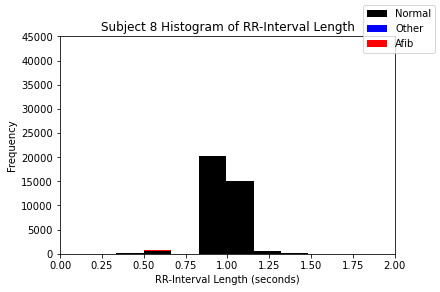

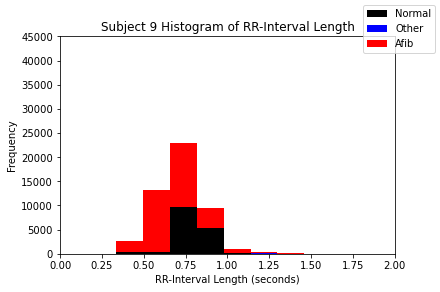

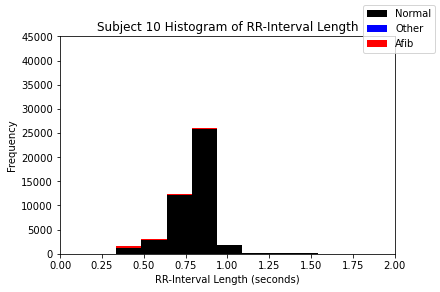

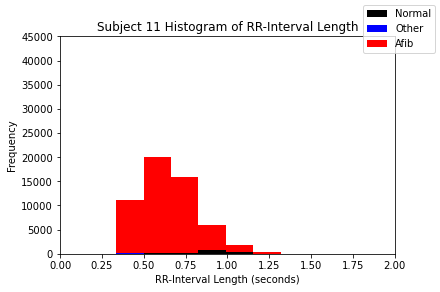

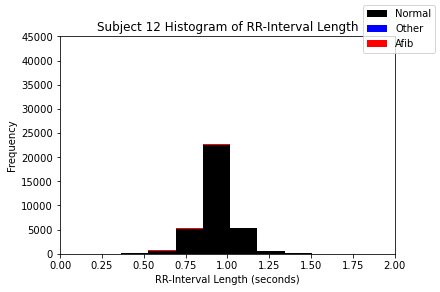

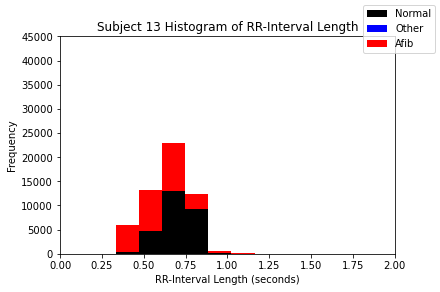

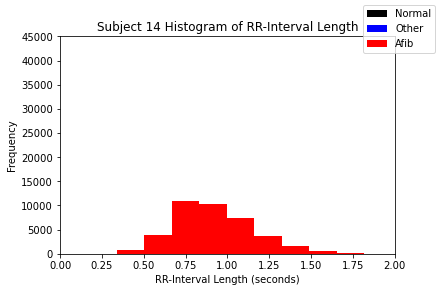

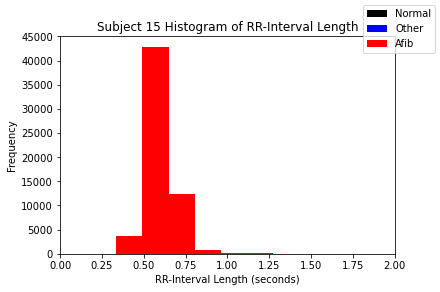

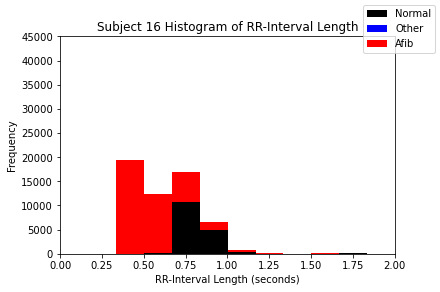

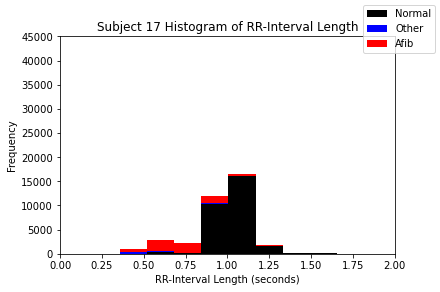

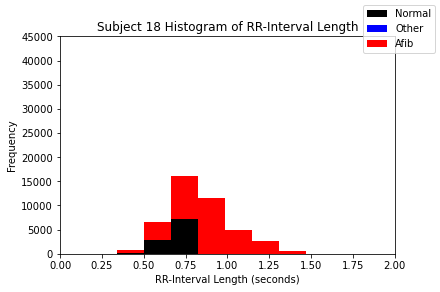

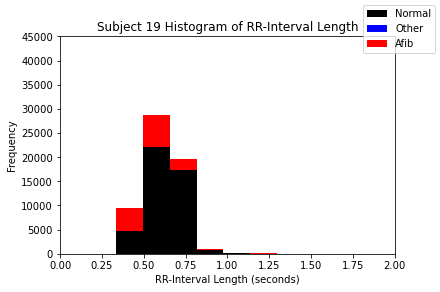

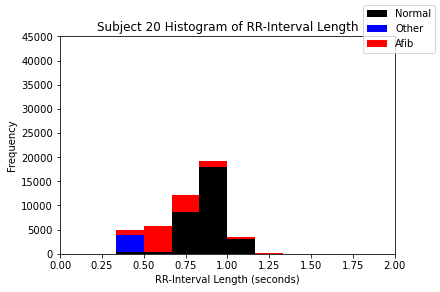

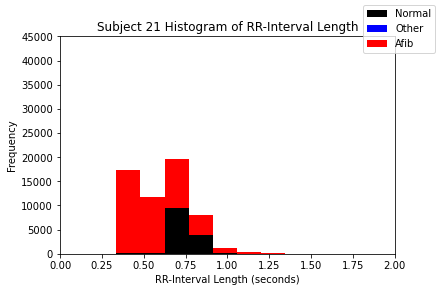

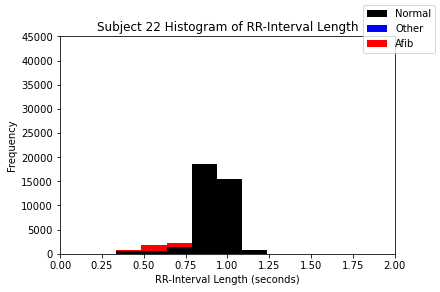

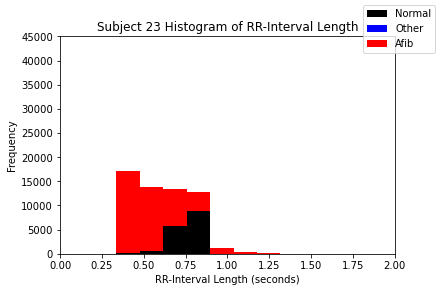

In [51]:
colors = ['black', 'b', 'r']
labels = ['Normal', 'Other', 'Afib']
bins = 7
integer = 0
for df in tqdm(subject_list):
    normal_list = []
    other_list = []
    afib_list = []
    counter = 0
    
    fig, axs = plt.subplots()
    plt.title('Subject ' + str(integer+1) + ' Histogram of RR-Interval Length')
    plt.xlabel('RR-Interval Length (seconds)')
    plt.ylabel('Frequency')
    axs.set_xlim(0, 2)
    axs.set_ylim(0, 45000)
    
    for item in df['Rhythm']:
        if item == 'N':
            normal_list.append(df['Interval'].iloc[counter])
            counter += 1
        elif item == 'O':
            other_list.append(df['Interval'].iloc[counter])
            counter += 1
        elif item == 'A':
            afib_list.append(df['Interval'].iloc[counter])
            counter += 1
    integer += 1
    axs.hist([normal_list, other_list, afib_list], stacked = True, color=colors, label = labels)
    fig.legend(loc='upper right')
    #axs.set_facecolor('limegreen')

In [12]:
def subset_subject(subjdf, interval_length = 25):
    interval_list = []
    subset_list = []
    counter = 0
    for item in subjdf['Interval']:
        subset_list.append(item)
        counter += 1
        if counter == interval_length:
            interval_list.append(subset_list)
            subset_list = []
            counter = 0
    rhythm_list = []
    rhythmsub_list = []
    counter = 0
    for item in subjdf['Rhythm']:
        rhythmsub_list.append(item)
        counter += 1
        if counter == interval_length:
            rhythm_list.append(rhythmsub_list)
            rhythmsub_list = []
            counter = 0
    subsetdf = []
    for index, item in enumerate(interval_list):
        newdf = pd.DataFrame(
            {
                'Interval':item,
                'Rhythm':rhythm_list[index]
            }
        )
        subsetdf.append(newdf)
    return subsetdf



def rmean(subsetdf):
    rmean_total = []
    for item in subsetdf:
        rmean_list = []
        rmean_cur = .75 + 0.25 * item['Interval'][0]
        rmean_list.append(rmean_cur)
        rmean_pre = rmean_cur
        for num in range(1,len(item)):
            rmean_cur = .75 * rmean_pre + 0.25 * item['Interval'][num]
            rmean_list.append(rmean_cur)
            rmean_pre = rmean_cur
        rmean_total.append(rmean_list)
    return rmean_total


def drmean(subsetdf):
    drmean_total = []
    for item in subsetdf:
        drmean_list = []
        rmean_cur = .75 + 0.25 * item['Interval'][0]
        drmean = 0
        drmean_list.append(drmean)
        rmean_pre = rmean_cur
        for num in range(1,len(item)):
            rmean_cur = .75 * rmean_pre + 0.25 * item['Interval'][num]
            drmean = rmean_cur - rmean_pre
            drmean_list.append(drmean)
            rmean_pre = rmean_cur
        drmean_total.append(drmean_list)
    return drmean_total

def variance_func():
    counter = 0
    subject_variance = []
    for subject in tqdm(subset_dataframes):
        variance_list = []
        for interval in subject:
            sub_counter = 0
            summation = 0
            for values in interval['Interval']:
                difference = values - subject_mean[counter][sub_counter]
                difference = difference ** 2

                summation += difference
            summation = summation / len(interval['Interval'])
            summation = summation ** 0.5
            variance_list.append(summation)
        subject_variance.append(variance_list)
    return subject_variance

def prob_chunk(chunk):
    norm_chunk = 0
    other_chunk = 0
    afib_chunk = 0
    for rhythm in chunk['Rhythm']:
        if rhythm == 'N':
            norm_chunk += 1
        elif rhythm == 'O':
            other_chunk += 1
        elif rhythm == 'A':
            afib_chunk +=1
    #temp_list = [norm_chunk, other_chunk, afib_chunk]
    #maximum = max(temp_list)
    denom = afib_chunk + norm_chunk + other_chunk
    #print(norm_chunk, other_chunk, afib_chunk)
    prob = [norm_chunk/denom, other_chunk/denom, afib_chunk/denom]
    return prob

In [13]:
subset_dataframes = []
for num in tqdm(range(0,23)):
    subjsubdf = subset_subject(subject_list[num])
    subrmean = rmean(subset_subject(subject_list[num]))
    subdrmean = drmean(subset_subject(subject_list[num]))
    for i in range(0,len(subjsubdf)):
        subjsubdf[i] = subjsubdf[i].assign(rmean=subrmean[i])
        subjsubdf[i] = subjsubdf[i].assign(drmean=subdrmean[i])
    subset_dataframes.append(subjsubdf)

100%|██████████| 23/23 [01:11<00:00,  3.12s/it]


In [14]:
subject_mean = []
for subject in tqdm(subset_dataframes):
    for interval in subject:
        temp_mean = 0
        mean_list = []
        for values in interval['Interval']:
            temp_mean += values
        temp_mean = temp_mean / len(interval['Interval'])
        mean_list.append(temp_mean)
    subject_mean.append(mean_list)


100%|██████████| 23/23 [00:02<00:00,  8.85it/s]


C:\Users\Luke\AppData\Local\Temp\ipykernel_2500\3902079012.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize=(15,3))


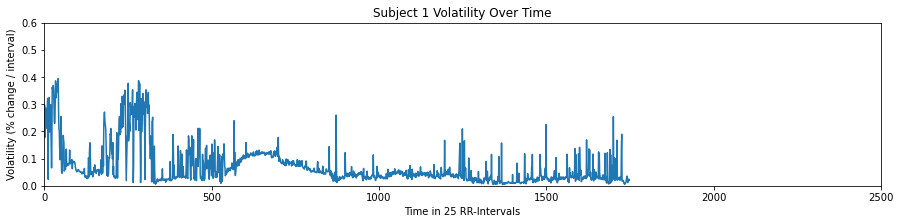

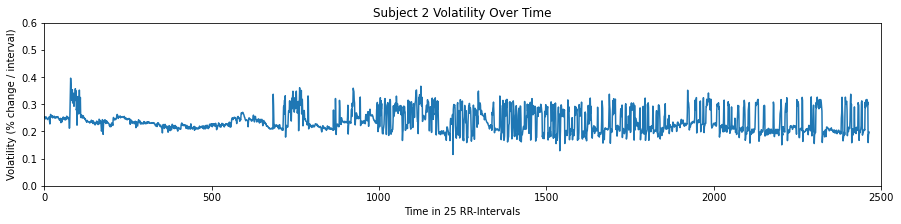

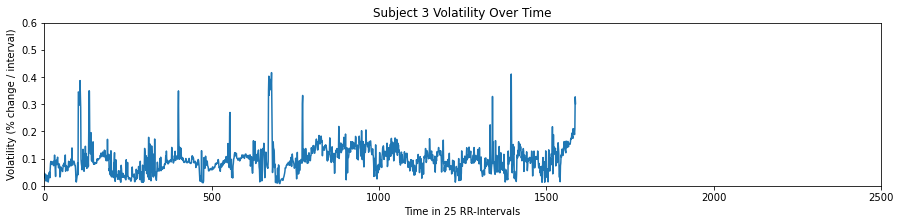

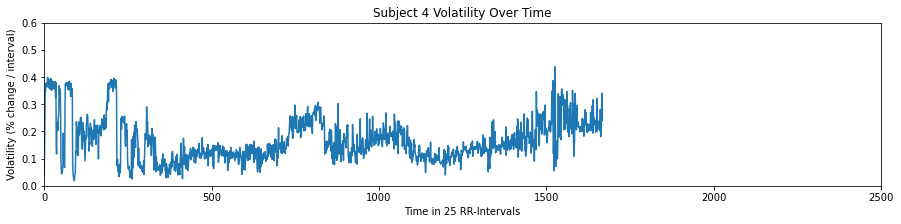

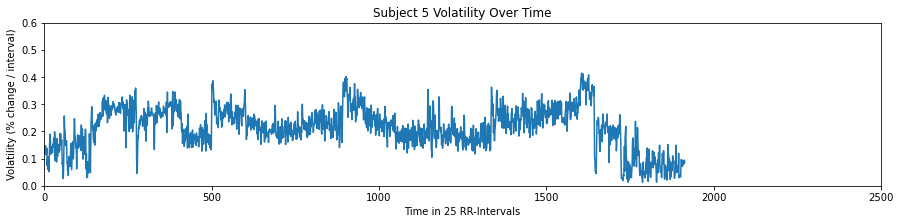

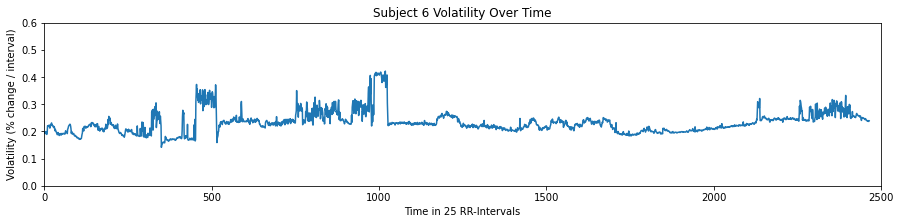

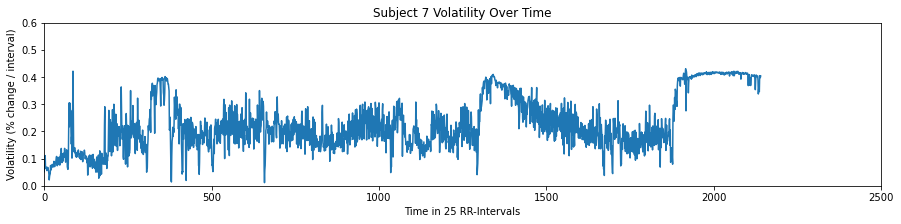

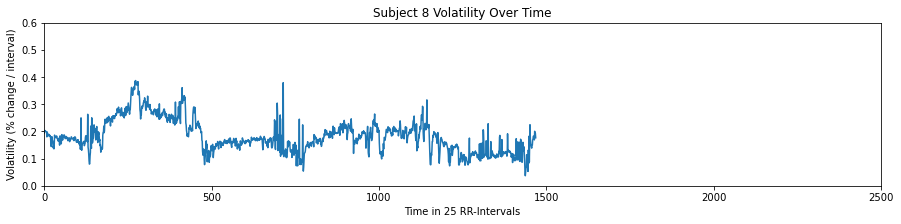

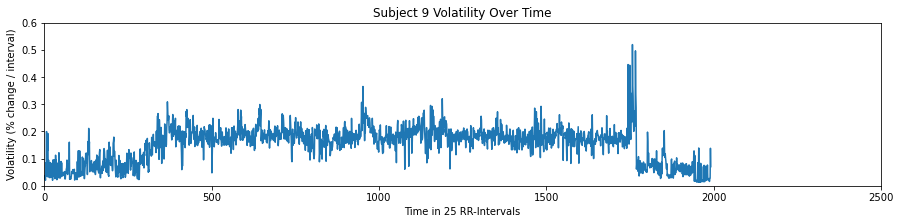

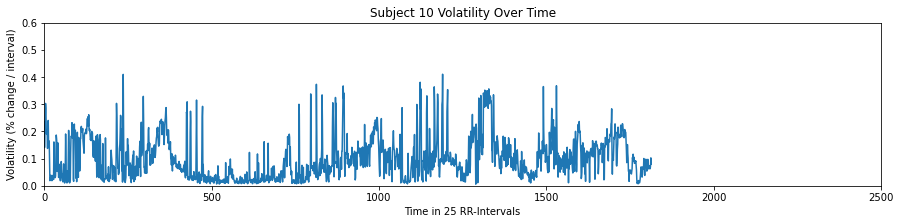

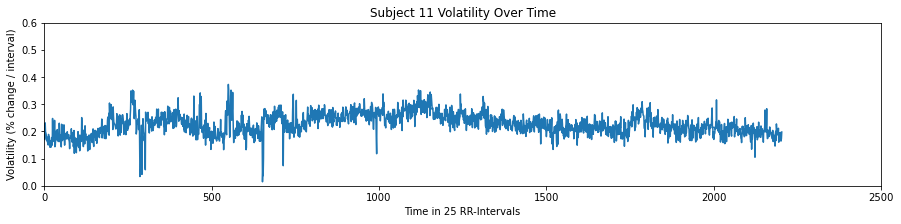

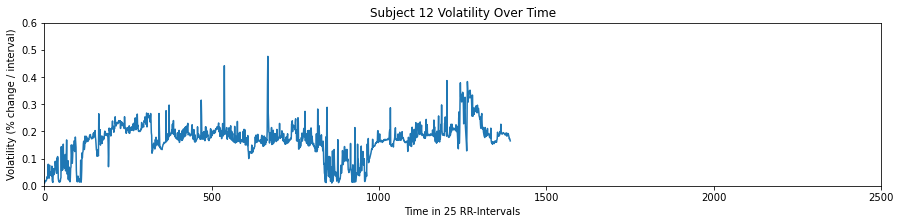

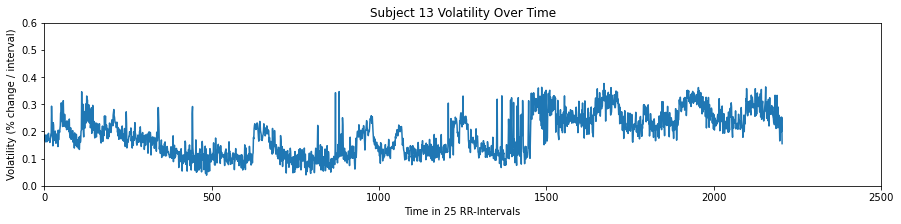

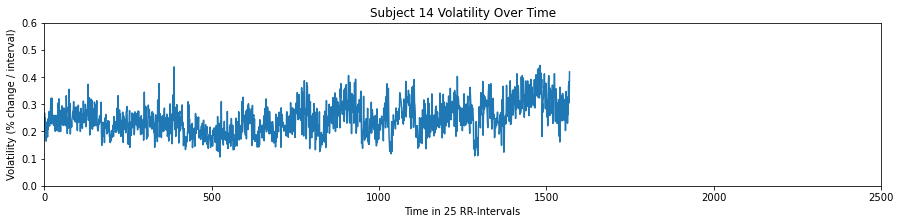

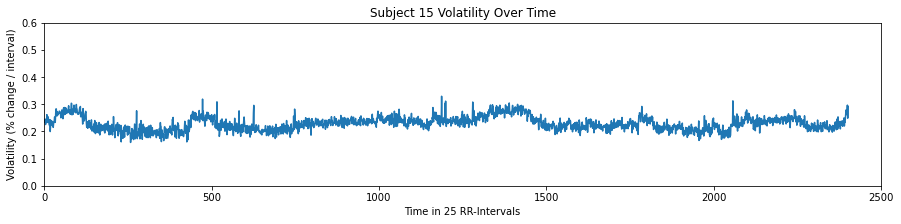

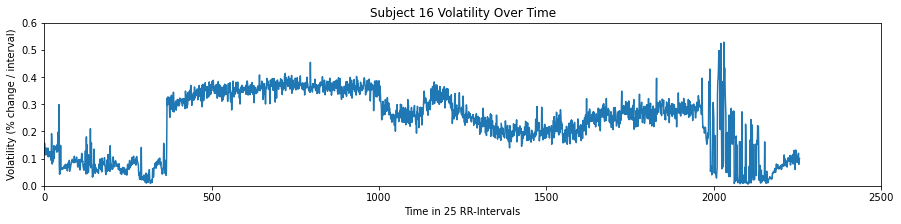

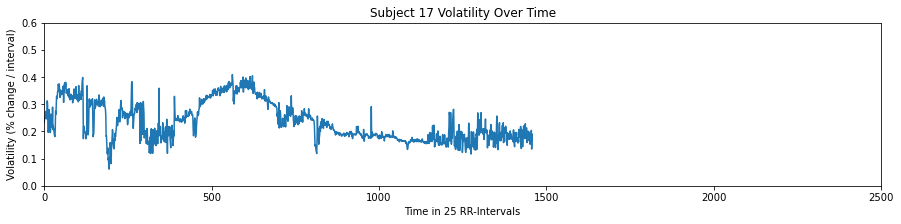

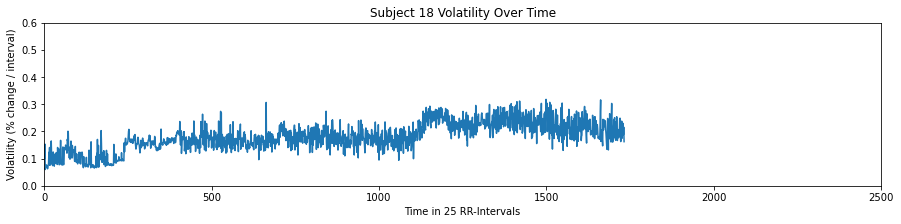

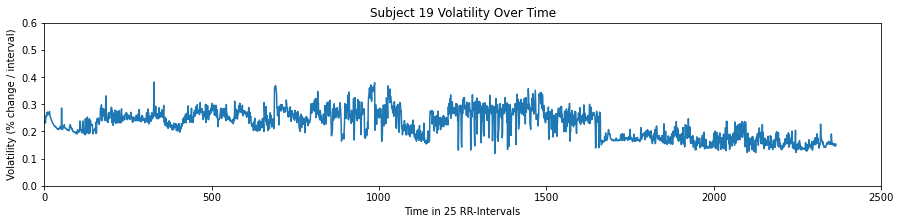

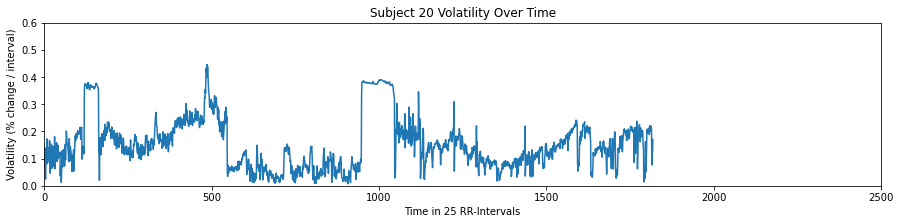

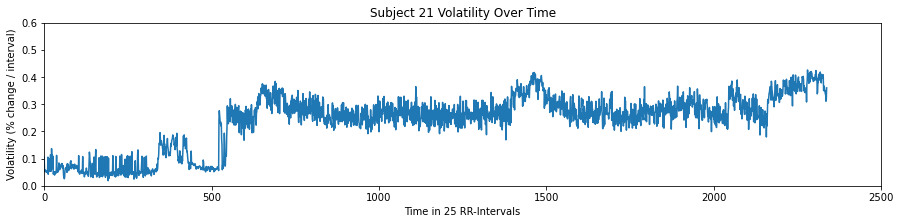

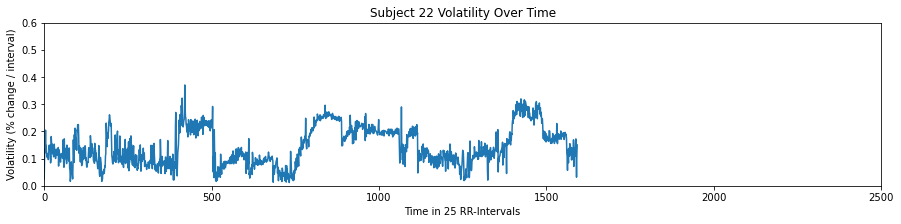

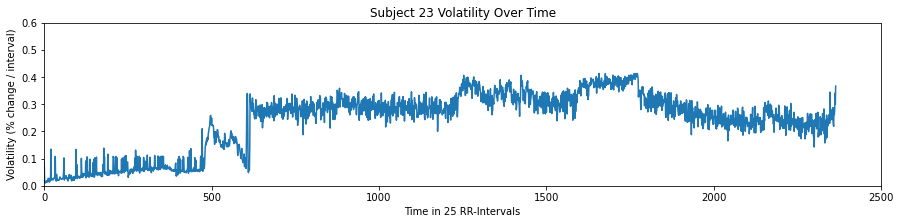

In [145]:
#fig, axs = plt.subplots()
subject_variance = variance_func()

for index, subject in enumerate(subject_variance):
    fig, axs = plt.subplots(figsize=(15,3))
    axs.plot(subject)
    plt.xlabel('Time in 25 RR-Intervals')
    plt.ylabel('Volatility (% change / interval)')
    plt.title('Subject ' + str(index + 1) + ' Volatility Over Time')
    axs.set_xlim([0, 2500])
    axs.set_ylim([0, 0.6])

In [15]:
chunk_prob = []
for subject in subset_dataframes:
    temp_chunk = []
    for chunks in subject:
        temp = prob_chunk(chunks)
        temp_chunk.append(temp)
    chunk_prob.append(temp_chunk)

In [16]:
shannon_main = []
for subject in chunk_prob:
    chunk_shannon = []
    for chunk in subject:
        shannon_entropy = 0
        for individualprob in chunk:
            if individualprob != 0:
                temp_var = individualprob * np.log(individualprob)
                shannon_entropy += -temp_var
            else:
                continue
        chunk_shannon.append(shannon_entropy)
    shannon_main.append(chunk_shannon)


C:\Users\Luke\AppData\Local\Temp\ipykernel_23576\1082122056.py:8: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  axs.set_ylim([0, max(subject)])
C:\Users\Luke\AppData\Local\Temp\ipykernel_23576\1082122056.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize=(15,3))


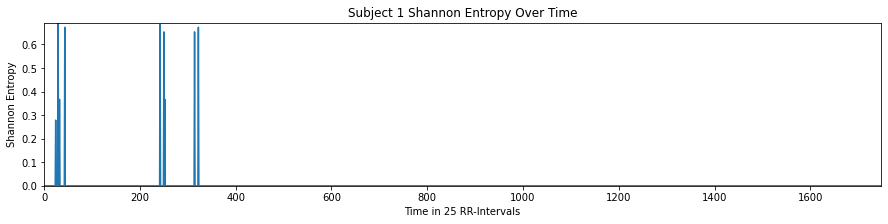

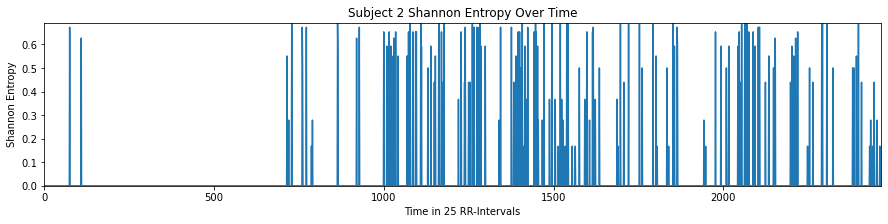

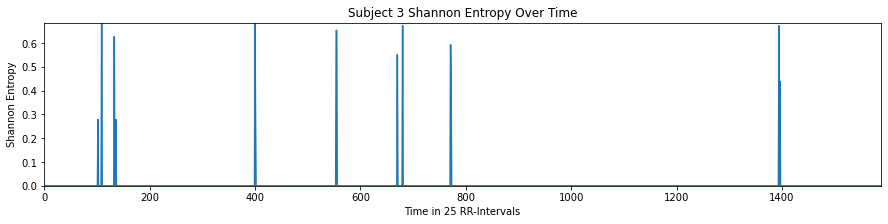

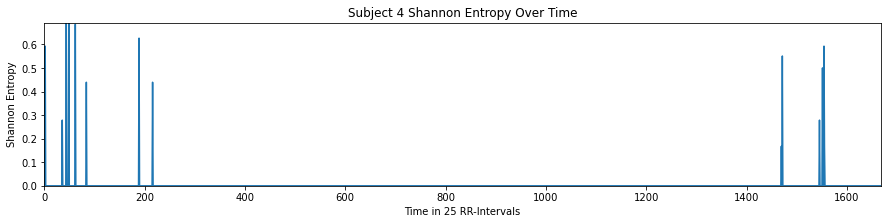

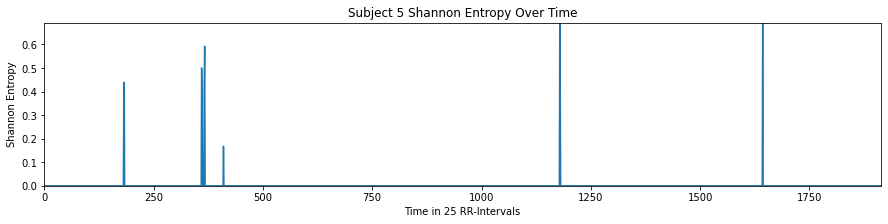

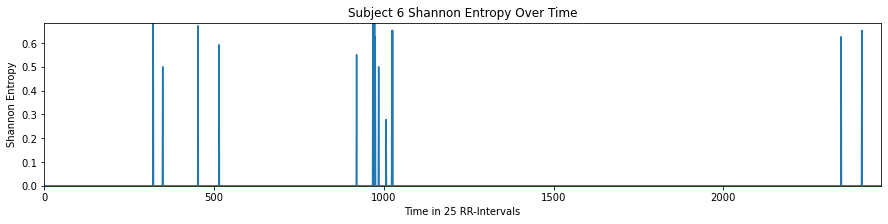

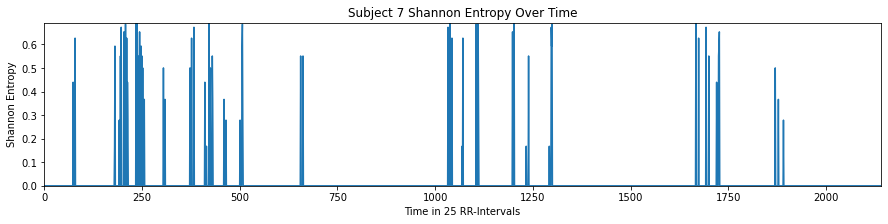

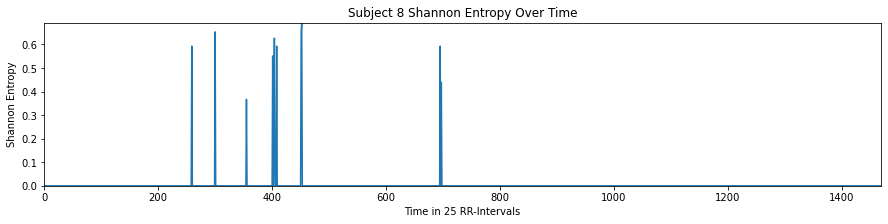

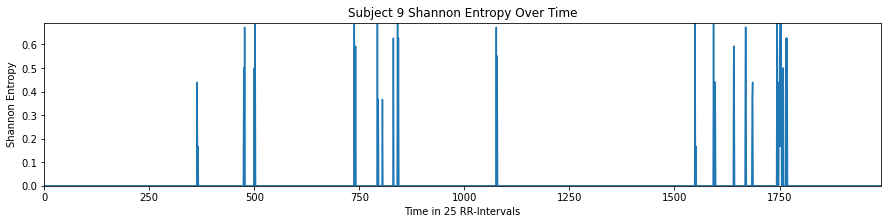

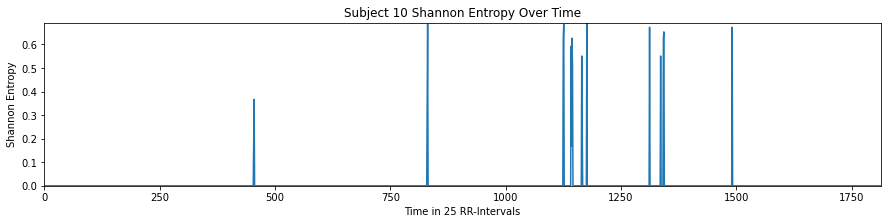

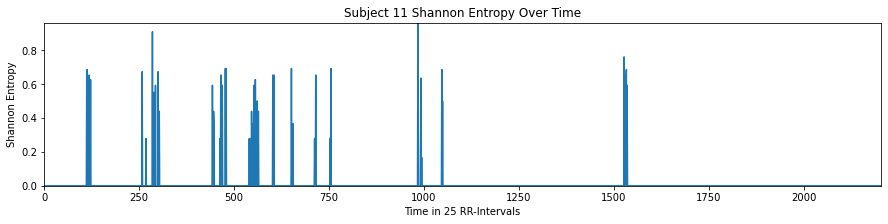

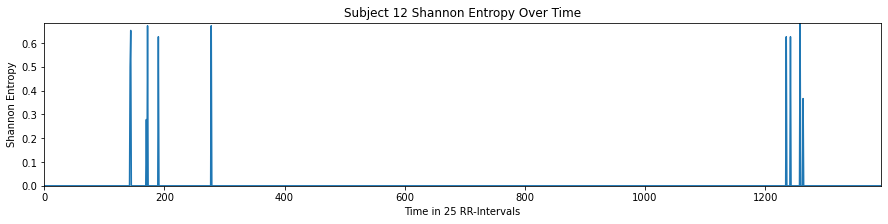

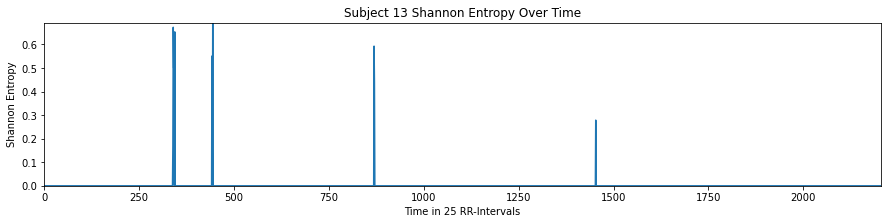

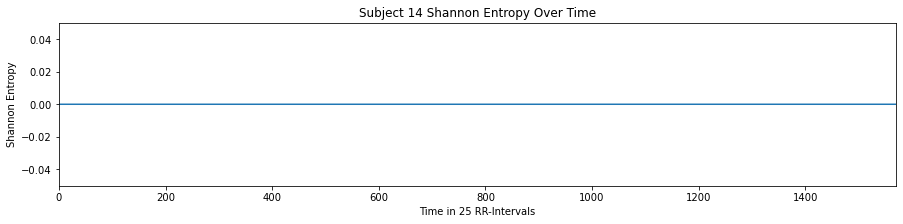

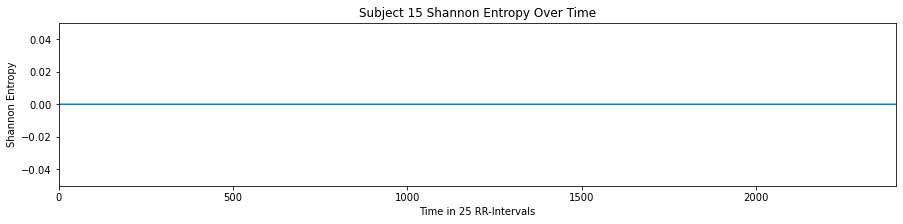

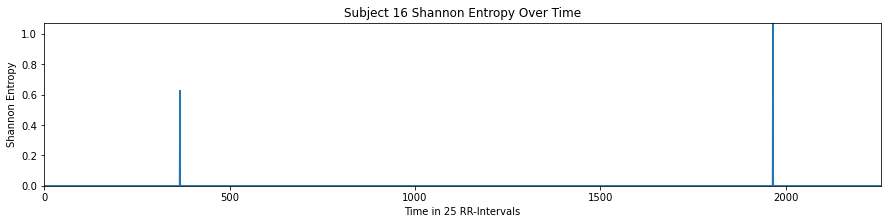

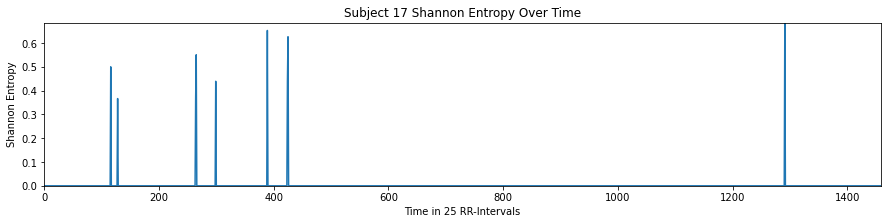

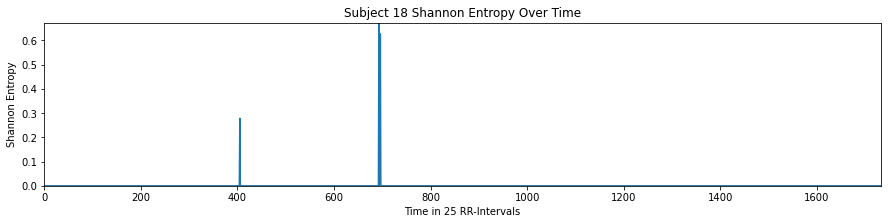

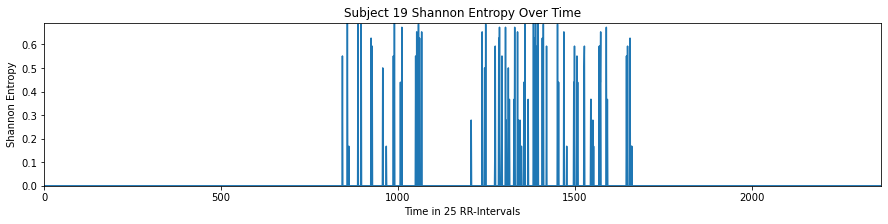

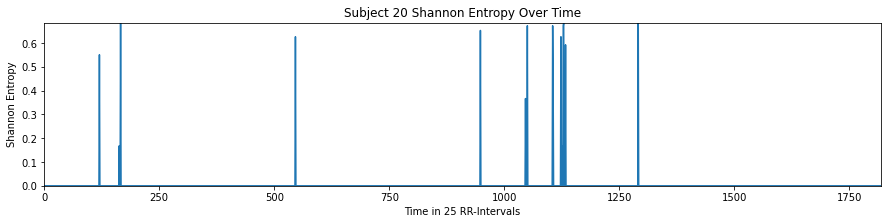

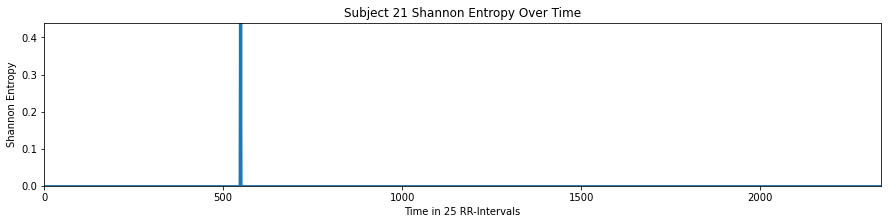

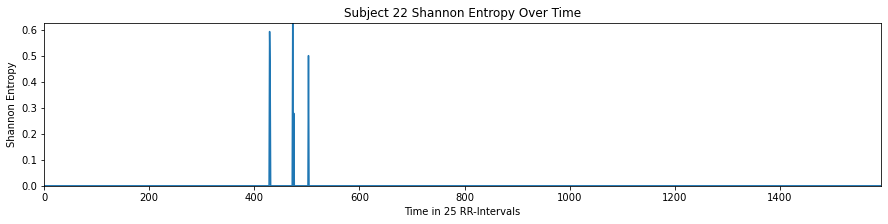

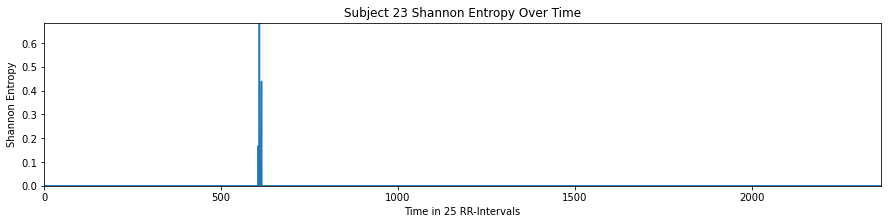

In [27]:
for index, subject in enumerate(shannon_main):
    fig, axs = plt.subplots(figsize=(15,3))
    axs.plot(subject)
    plt.xlabel('Time in 25 RR-Intervals')
    plt.ylabel('Shannon Entropy')
    plt.title('Subject ' + str(index + 1) + ' Shannon Entropy Over Time')
    axs.set_xlim([0, len(subject)])
    axs.set_ylim([0, max(subject)])

In [18]:
#Classifying transitions between RR-Ints as short, medium, or long using running mean
int_types = []

for subject in tqdm(subset_dataframes):
    #list of types of rr_ints for each subject
    subject_types = []
    for chunk in subject:
        subset_types = []
        counter = 0
        for rr_ints in chunk['Interval']:
            if rr_ints < 0.85 * chunk['rmean'][counter]: 
                #if rr_ints is less than 85% of runningmean
                #label subject type as short
                subset_types.append('short')
                counter += 1
            elif rr_ints > 1.15 * chunk['rmean'][counter]: 
                #if rr_ints is greater than 115% of runningmean
                #label subject type as long
                subset_types.append('long')
                counter += 1
            else:
                #label subject type as regular
                subset_types.append('regular')
                counter += 1
        subject_types.append(subset_types)
    int_types.append(subject_types)



100%|██████████| 23/23 [00:10<00:00,  2.14it/s]


In [19]:
#Classifying transitions between RR-Ints as short, medium, or long using running mean
transitions_list=[]

for idx, subject in enumerate(int_types): 
    subject_transitions = []
    for j, subset in enumerate(subject):
        StoS, StoR, StoL, RtoS, RtoR, RtoL, LtoS, LtoR, LtoL = [0]*9
        count = 0
        for i, rr_int in enumerate(subset):
            if i<len(subset)-1:
                count += 1
                if subset[i]== 'short' and subset[i+1]== 'short':
                  #if subset is short to short
                  #add one to the StoS counter
                    StoS += 1

                elif subset[i]== 'short' and subset[i+1]== 'regular':
                  #if subset is short to regular
                  #add one to the StoR counter
                    StoR += 1

                elif subset[i]== 'short' and subset[i+1]== 'long':
                  #if subset is short to long
                  #add one to the StoL counter
                    StoL += 1
                    
                elif subset[i]== 'regular' and subset[i+1]== 'regular':
                  #if subset is short to short
                  #add one to the StoS counter
                    RtoR += 1

                elif subset[i]== 'regular' and subset[i+1]== 'long':
                  #if subset is short to regular
                  #add one to the StoR counter
                    RtoL += 1

                elif subset[i]== 'regular' and subset[i+1]== 'short':
                  #if subset is short to long
                  #add one to the StoL counter
                    RtoS += 1
                    
                elif subset[i]== 'long' and subset[i+1]== 'short':
                  #if subset is short to short
                  #add one to the StoS counter
                    LtoS += 1

                elif subset[i]== 'long' and subset[i+1]== 'regular':
                  #if subset is short to regular
                  #add one to the StoR counter
                    LtoR += 1

                elif subset[i]== 'long' and subset[i+1]== 'long':
                  #if subset is short to long
                  #add one to the StoL counter
                    LtoL += 1

                #repeat for... 
                #regular to short
                #regular to regular
                #regular to long
                #long to short
                #long to regular
                #long to long
        subject_transitions.append([StoS/count, StoR/count, StoL/count, RtoS/count, RtoR/count, RtoL/count, LtoS/count, LtoR/count, LtoL/count])
    transitions_list.append(subject_transitions)

In [20]:
#Standard deviation
Std_list = []
for subject in subset_dataframes:
    Standard_devs = []
    for chunk in subject:
        standard_dev = np.std(chunk['Interval'])
        Standard_devs.append(standard_dev)
    Std_list.append(Standard_devs)

In [21]:
CoefVar_list = []
for subject in subset_dataframes:
    variance_list = []
    for chunk in subject:
        variance = np.std(chunk['Interval'])/np.mean(chunk['Interval'])
        variance_list.append(variance)
    CoefVar_list.append(variance_list)

In [22]:
Range_list = []
for subject in subset_dataframes:
    range_array = []
    for chunk in subject:
        ranges = max(chunk['Interval']) - min(chunk['Interval'])
        range_array.append(ranges)
    Range_list.append(range_array)

In [29]:
def difference_count(vector, m, r):
    vector_list = []
    temp_list = []
    master_arr = []
    for idx, pos in enumerate(vector):
        temp_list.append(pos)
        if (idx + 1) % m == 0:
            vector_list.append(temp_list)
            temp_list = []
        elif (idx + 1) == len(vector):
            vector_list.append(temp_list)
            temp_list = []

    for i in range(0, len(vector_list)):
        count = 0
        for j in range(0, len(vector_list)):
            difference_list = []
            
            if len(vector_list[i]) == len(vector_list[j]) == m:    
                for num in range(0, m):
                    diff = vector_list[j][num] - vector_list[i][num]
                    difference_list.append(abs(diff))
            else:        
                if len(vector_list[i]) < len(vector_list[j]):
                    for num in range(0, len(vector_list[i])):
                        diff = vector_list[j][num] - vector_list[i][num]
                        difference_list.append(abs(diff))
                else:
                    for num in range(0, len(vector_list[j])):
                        diff = vector_list[j][num] - vector_list[i][num]
                        difference_list.append(abs(diff))
                
            if max(difference_list) <= r:
                count += 1
                
        master_arr.append(count)
    return master_arr

def app_entropy(vector, m, r):
    N = len(vector)
    master_arr = difference_count(vector, m, r)
    summation = 0
    for i in range(0, len(master_arr)):
        value = np.log(master_arr[i])
        summation += value
    
    app = summation / (N - m + 1)
    return app

def samp_entropy(vector, m, r):
    mplusone = m + 1
    num_arr = difference_count(vector, mplusone, r)
    denom_arr = difference_count(vector, m, r)
    numerator = 0
    denom = 0

    for i in range(0, len(num_arr)):
        value = num_arr[i] - 1
        numerator += value
    for i in range(0, len(denom_arr)):
        value = denom_arr[i] - 1
        denom += value
    return -np.log(numerator/denom)

In [33]:
appen_main = []
sampen_main = []
for subject in tqdm(subset_dataframes):
    temp_app_arr = []
    temp_samp_arr = []
    for subsection in subject:
        difference_count(subsection['Interval'], 1, 0.1)
        temp_app = app_entropy(subsection['Interval'], 1, 0.1)
        temp_samp = samp_entropy(subsection['Interval'], 1, 0.1)
        temp_app_arr.append(temp_app)
        temp_samp_arr.append(temp_samp)
    appen_main.append(temp_app_arr)
    sampen_main.append(temp_samp_arr)

100%|██████████| 23/23 [01:06<00:00,  2.87s/it]


In [79]:
features_model = []
counter = -1

for subject in subset_dataframes:
    counter += 1

    tempdf = pd.DataFrame(
                                
        data = np.transpose(np.array([
                                        [x[0] for x in transitions_list[counter]],
                                        [x[1] for x in transitions_list[counter]],
                                        [x[2] for x in transitions_list[counter]],
                                        [x[3] for x in transitions_list[counter]],
                                        [x[4] for x in transitions_list[counter]],
                                        [x[5] for x in transitions_list[counter]],
                                        [x[6] for x in transitions_list[counter]],
                                        [x[7] for x in transitions_list[counter]],
                                        [x[8] for x in transitions_list[counter]],
                                        Std_list[counter],
                                        CoefVar_list[counter],
                                        Range_list[counter]
                                        ])
                               ),


        columns = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS', 'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range']
        
        
    )
    tempvar1 = appen_main[counter]
    tempvar2 = sampen_main[counter]
    
    tempdf = tempdf.assign(AppEn=tempvar1)
    tempdf.assign(SampEn=tempvar2)
    features_model.append(tempdf)

In [80]:
features_model[0]

,StoS,StoR,StoL,RtoS,RtoR,RtoL,LtoS,LtoR,LtoL,STD,CoefVar,Range,AppEn,SampEn
0,0.250000,0.125000,0.083333,0.083333,0.208333,0.083333,0.083333,0.041667,0.041667,0.180045,0.259401,0.620,2.248025,2.019338
1,0.208333,0.166667,0.041667,0.166667,0.291667,0.041667,0.041667,0.041667,0.000000,0.181063,0.314259,0.584,2.131150,1.680534
2,0.083333,0.083333,0.166667,0.041667,0.375000,0.041667,0.166667,0.041667,0.000000,0.176833,0.224044,0.620,2.086226,1.876917
3,0.166667,0.125000,0.000000,0.083333,0.416667,0.083333,0.041667,0.041667,0.041667,0.166312,0.240948,0.544,2.148550,1.945910
4,0.291667,0.208333,0.041667,0.125000,0.000000,0.125000,0.166667,0.000000,0.041667,0.190016,0.289659,0.552,2.097824,2.236834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1743,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.011808,0.014536,0.064,3.218876,1.347074
1744,0.000000,0.041667,0.000000,0.000000,0.958333,0.000000,0.000000,0.000000,0.000000,0.020241,0.024859,0.088,3.218876,1.347074
1745,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.016860,0.020821,0.076,3.218876,1.347074
1746,0.000000,0.041667,0.000000,0.000000,0.958333,0.000000,0.000000,0.000000,0.000000,0.024815,0.030645,0.080,3.218876,1.347074


In [81]:
#sample_vect = [1,2,3,1,2,3,1,2,3]
#print(app_entropy(sample_vect, 3, 2))
#difference_count(sample_vect, 3, 2)
#print(samp_entropy(sample_vect, 3, 2))

## Save the RR-Intervals 

In [ ]:
# In this block use the code we looked at on 6/30 as a reference to save our rr-intervals as a .CSV

## What else to extract - some good places to start

- [Moody, 1983 - A new method for detecting atrial fibrillation using R-R intervals.](http://ecg.mit.edu/george/publications/afib-cinc-1983.pdf)
- [Lake, 2010 - Accurate estimation of entropy in very short physiological time series: the problem of atrial fibrillation detection in implanted ventricular devices](https://journals.physiology.org/doi/full/10.1152/ajpheart.00561.2010)
- [Rubio, 2011 - Estudio comparativo de algoritmos para la deteccion de la fibrilacion auricular](https://academica-e.unavarra.es/bitstream/handle/2454/4136/577570.pdf?sequence=1&isAllowed=y)
- [Ghodrati, 2008 - Statistical analysis of RR interval irregularities for detection of atrial fibrillation](https://ieeexplore.ieee.org/document/4749227)
- [Young, 1999 - A comparative study of a hidden Markov model detector for atrial fibrillation](https://ieeexplore.ieee.org/abstract/document/788166)